In [143]:
from pyspark.sql.functions import dayofweek
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import col,when,count
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType,DoubleType
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark import SparkConf, SparkContext
import os
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.mllib.stat import Statistics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import HashingTF,Tokenizer,IDF
import pyspark.sql.types as T
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.functions import col, explode, array, lit
from pyspark.ml.classification import LinearSVC
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.sql.functions import col, explode, array, lit
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics

In [110]:
# mostrar el esquema
spark = SparkSession.builder.appName('ml-eshop').getOrCreate()
df = spark.read.format("csv").option("delimiter", ";").option("header",True).load("dataset.csv")
df.printSchema()

root
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- order: string (nullable = true)
 |-- country: string (nullable = true)
 |-- session ID: string (nullable = true)
 |-- page 1 (main category): string (nullable = true)
 |-- page 2 (clothing model): string (nullable = true)
 |-- colour: string (nullable = true)
 |-- location: string (nullable = true)
 |-- model photography: string (nullable = true)
 |-- price: string (nullable = true)
 |-- price 2: string (nullable = true)
 |-- page: string (nullable = true)



In [111]:
# visualización previa con pandas
def head(df):
    return pd.DataFrame(df.take(10), columns = df.columns)
head(df)

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1
5,2008,4,1,6,29,1,3,C56,6,1,2,57,1,4
6,2008,4,1,7,29,1,3,C57,5,1,2,33,2,4
7,2008,4,1,8,29,1,4,P67,9,5,1,38,1,4
8,2008,4,1,9,29,1,4,P82,6,4,2,48,1,5
9,2008,4,1,1,29,2,2,B31,9,5,1,57,1,2


In [112]:
# atributos
df.columns

['year',
 'month',
 'day',
 'order',
 'country',
 'session ID',
 'page 1 (main category)',
 'page 2 (clothing model)',
 'colour',
 'location',
 'model photography',
 'price',
 'price 2',
 'page']

In [113]:
# hay datos faltantes?
#df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show() 

+----+-----+---+-----+-------+----------+----------------------+-----------------------+------+--------+-----------------+-----+-------+----+
|year|month|day|order|country|session ID|page 1 (main category)|page 2 (clothing model)|colour|location|model photography|price|price 2|page|
+----+-----+---+-----+-------+----------+----------------------+-----------------------+------+--------+-----------------+-----+-------+----+
|   0|    0|  0|    0|      0|         0|                     0|                      0|     0|       0|                0|    0|      0|   0|
+----+-----+---+-----+-------+----------+----------------------+-----------------------+------+--------+-----------------+-----+-------+----+



In [114]:
# tipos de datos cargados
df.dtypes

[('year', 'string'),
 ('month', 'string'),
 ('day', 'string'),
 ('order', 'string'),
 ('country', 'string'),
 ('session ID', 'string'),
 ('page 1 (main category)', 'string'),
 ('page 2 (clothing model)', 'string'),
 ('colour', 'string'),
 ('location', 'string'),
 ('model photography', 'string'),
 ('price', 'string'),
 ('price 2', 'string'),
 ('page', 'string')]

In [115]:
# castear todos los numeros cargados como string a int
for col in df.columns:
    if col!= "page 2 (clothing model)":
        df = df.withColumn(col,df[col].cast(IntegerType()))

In [116]:
# verificacion de la conversion
df.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('order', 'int'),
 ('country', 'int'),
 ('session ID', 'int'),
 ('page 1 (main category)', 'int'),
 ('page 2 (clothing model)', 'string'),
 ('colour', 'int'),
 ('location', 'int'),
 ('model photography', 'int'),
 ('price', 'int'),
 ('price 2', 'int'),
 ('page', 'int')]

In [117]:
# borrar la columna año (todos son 2008)
df = df.drop('year')
head(df)

,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,4,1,5,29,1,2,B8,4,3,2,52,1,1
5,4,1,6,29,1,3,C56,6,1,2,57,1,4
6,4,1,7,29,1,3,C57,5,1,2,33,2,4
7,4,1,8,29,1,4,P67,9,5,1,38,1,4
8,4,1,9,29,1,4,P82,6,4,2,48,1,5
9,4,1,1,29,2,2,B31,9,5,1,57,1,2


In [118]:
# dataset shape
print(df.count(),len(df.columns))

(165474, 13)


In [119]:
df.describe().toPandas()

,summary,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,count,165474,165474,165474,165474,165474,165474,165474,165474,165474,165474,165474,165474,165474
1,mean,5.585886604542103,14.524553706322443,9.817475857234369,26.952620955557972,12058.417056455999,2.4008424284177576,None,6.2276550998948474,3.2581976624726545,1.260071068566663,43.802506738218696,1.4881673253804224,1.7101659475204565
2,stddev,1.328160047098383,8.8303740009431,13.478411349046278,7.1506909739811375,7008.418902897808,1.1444200219515601,None,4.235606081622808,1.7132057755634258,0.4386744473921791,12.548131195655683,0.49986147859752994,0.9824121539300674
3,min,4,1,1,1,1,1,A1,1,1,1,18,1,1
4,max,8,31,195,47,24026,4,P9,14,6,2,82,2,5


In [120]:
# convertir atributo categorico a numerico
indexer = StringIndexer(inputCol="page 2 (clothing model)", outputCol="page2_num")
df = indexer.fit(df).transform(df)
df = df.drop('page 2 (clothing model)')
head(df)

,month,day,order,country,session ID,page 1 (main category),colour,location,model photography,price,price 2,page,page2_num
0,4,1,1,29,1,1,1,5,1,28,2,1,19.0
1,4,1,2,29,1,1,1,6,1,33,2,1,33.0
2,4,1,3,29,1,2,10,2,1,52,1,1,0.0
3,4,1,4,29,1,2,6,6,2,38,2,1,28.0
4,4,1,5,29,1,2,4,3,2,52,1,1,121.0
5,4,1,6,29,1,3,6,1,2,57,1,4,40.0
6,4,1,7,29,1,3,5,1,2,33,2,4,71.0
7,4,1,8,29,1,4,9,5,1,38,1,4,192.0
8,4,1,9,29,1,4,6,4,2,48,1,5,82.0
9,4,1,1,29,2,2,9,5,1,57,1,2,31.0


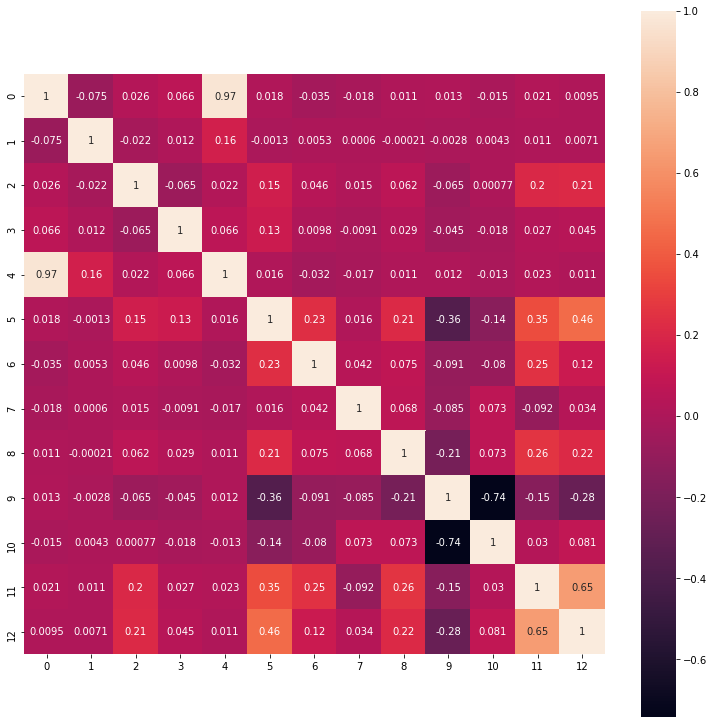

In [121]:
# get correlation matrix
import seaborn as sns
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol = vector_col)
df_vector = assembler.transform(df).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)
corr_matrix = list(matrix.collect()[0]["pearson({})".format(vector_col)].values)
#print(arr)
row_N,col_N,i,j = len(corr_matrix),len(df.columns),0,0
matrix_corr = []
while i < row_N:
    j = 0
    tmp = []
    while j < col_N:
        #print(corr_matrix[i].round(2),end = "\n" if j+1 == col_N else " ")
        tmp.append(corr_matrix[i])
        i += 1
        j += 1
    matrix_corr.append(list(tmp))
    #i += 1
plt.figure(figsize = (13,13))
ax = sns.heatmap(matrix_corr, square=True, annot=True)

In [122]:
# borrar la corr > 0.9
#df = df.drop('month')
df = df.drop('session ID')
head(df)

,month,day,order,country,page 1 (main category),colour,location,model photography,price,price 2,page,page2_num
0,4,1,1,29,1,1,5,1,28,2,1,19.0
1,4,1,2,29,1,1,6,1,33,2,1,33.0
2,4,1,3,29,2,10,2,1,52,1,1,0.0
3,4,1,4,29,2,6,6,2,38,2,1,28.0
4,4,1,5,29,2,4,3,2,52,1,1,121.0
5,4,1,6,29,3,6,1,2,57,1,4,40.0
6,4,1,7,29,3,5,1,2,33,2,4,71.0
7,4,1,8,29,4,9,5,1,38,1,4,192.0
8,4,1,9,29,4,6,4,2,48,1,5,82.0
9,4,1,1,29,2,9,5,1,57,1,2,31.0


In [123]:
df.dtypes

[('month', 'int'),
 ('day', 'int'),
 ('order', 'int'),
 ('country', 'int'),
 ('page 1 (main category)', 'int'),
 ('colour', 'int'),
 ('location', 'int'),
 ('model photography', 'int'),
 ('price', 'int'),
 ('price 2', 'int'),
 ('page', 'int'),
 ('page2_num', 'double')]

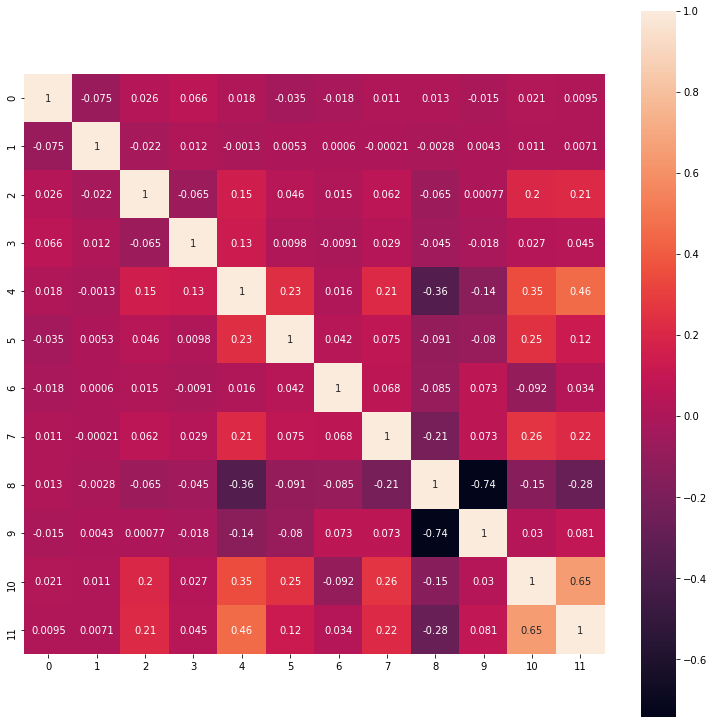

In [124]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol = vector_col)
df_vector = assembler.transform(df).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)
corr_matrix = list(matrix.collect()[0]["pearson({})".format(vector_col)].values)
#print(arr)
row_N,col_N,i,j = len(corr_matrix),len(df.columns),0,0
matrix_corr = []
while i < row_N:
    j = 0
    tmp = []
    while j < col_N:
        #print(corr_matrix[i].round(2),end = "\n" if j+1 == col_N else " ")
        tmp.append(corr_matrix[i])
        i += 1
        j += 1
    matrix_corr.append(list(tmp))
    #i += 1
plt.figure(figsize = (13,13))
ax = sns.heatmap(matrix_corr, square=True, annot=True)

In [125]:
labeled = df.groupby("price").count()
labeled.show()

+-----+-----+
|price|count|
+-----+-----+
|   65|  402|
|   28|18262|
|   26|  844|
|   52| 9279|
|   20| 1433|
|   57|11884|
|   48|17878|
|   43|22751|
|   72| 1932|
|   55| 1199|
|   23| 3992|
|   77|  184|
|   50|  764|
|   38|33883|
|   82| 1923|
|   62|14383|
|   60| 1641|
|   33|18749|
|   67| 3811|
|   18|  280|
+-----+-----+



In [126]:
# selecciono los nombres de las columnas sin el target
names = list()
for i in df.columns:
    if i!="price":
        names.append(i)

In [127]:
# convierto a vectorAssembler para poder usar el modelo
vectorAssembler = VectorAssembler(inputCols = names, outputCol = 'features')
vhouse_df = vectorAssembler.transform(df)
vhouse_df = vhouse_df.select(['features', 'price'])


splits = vhouse_df.randomSplit([0.7, 0.3])

In [128]:
# parto en conjunto de prueba y entrenamiento
train_df = splits[0] 
test_df = splits[1] 
train_df.show()
test_df.show()

+--------------------+-----+
|            features|price|
+--------------------+-----+
|[4.0,1.0,1.0,9.0,...|   62|
|[4.0,1.0,1.0,9.0,...|   62|
|[4.0,1.0,1.0,9.0,...|   62|
|[4.0,1.0,1.0,9.0,...|   28|
|[4.0,1.0,1.0,9.0,...|   28|
|[4.0,1.0,1.0,9.0,...|   33|
|[4.0,1.0,1.0,9.0,...|   38|
|[4.0,1.0,1.0,9.0,...|   38|
|[4.0,1.0,1.0,9.0,...|   38|
|[4.0,1.0,1.0,9.0,...|   62|
|[4.0,1.0,1.0,9.0,...|   72|
|[4.0,1.0,1.0,9.0,...|   72|
|[4.0,1.0,1.0,9.0,...|   43|
|[4.0,1.0,1.0,9.0,...|   43|
|[4.0,1.0,1.0,9.0,...|   43|
|[4.0,1.0,1.0,9.0,...|   43|
|[4.0,1.0,1.0,9.0,...|   38|
|[4.0,1.0,1.0,9.0,...|   38|
|[4.0,1.0,1.0,9.0,...|   43|
|[4.0,1.0,1.0,9.0,...|   62|
+--------------------+-----+
only showing top 20 rows

+--------------------+-----+
|            features|price|
+--------------------+-----+
|[4.0,1.0,1.0,9.0,...|   72|
|[4.0,1.0,1.0,9.0,...|   43|
|[4.0,1.0,1.0,9.0,...|   43|
|[4.0,1.0,1.0,9.0,...|   62|
|[4.0,1.0,1.0,9.0,...|   38|
|[4.0,1.0,1.0,9.0,...|   43|
|[4.0,1.0,1.0,9.0

# Modelos de regresión sobre el precio de los artículos

# Modelo de Regresion Lineal

In [129]:
# se crea y entrena el modelo
lr = LinearRegression(featuresCol = 'features', labelCol='price', maxIter=100, regParam=0.2, elasticNetParam = 0.2)
lr_model = lr.fit(train_df)

# ahora se pueden hacer algunas predicciones y evaluar el desempeño 
lr_predictions = lr_model.transform(test_df)
test_prediction = lr_predictions.select("prediction","price")

test_prediction.show()

evaluator = RegressionEvaluator(labelCol="price")

print("R Squared (R2) on test data = %g" % evaluator.evaluate(test_prediction, {evaluator.metricName: "r2"}))
print("Root Mean Squared Error (RMSE) on test data = %g" % evaluator.evaluate(test_prediction, {evaluator.metricName: "rmse"}))

+------------------+-----+
|        prediction|price|
+------------------+-----+
|  61.1377665594283|   72|
|  41.3627358531668|   43|
|  41.3627358531668|   43|
|61.209151565451464|   62|
|41.301795801383115|   38|
|42.570287065159505|   43|
| 40.44251821948814|   28|
|37.623635407020984|   33|
|  54.1627167835659|   57|
| 55.82896584021269|   57|
| 54.45672207694777|   52|
|49.753942445215685|   48|
|  39.5138747926326|   38|
| 41.63096378808807|   38|
| 40.44251821948814|   28|
| 41.23766516514182|   43|
|37.623635407020984|   33|
|50.423133872785606|   55|
|  41.4560661901123|   38|
| 62.30140274878464|   62|
+------------------+-----+
only showing top 20 rows

R Squared (R2) on test data = 0.784623
Root Mean Squared Error (RMSE) on test data = 5.82584


# Regresión Lineal General (Gamma)

In [130]:
# se crea y entrena el modelo
glr = GeneralizedLinearRegression(featuresCol = 'features', labelCol='price',family="Gamma", link="identity", maxIter=10, regParam=0.3)

# Fit the model
model = glr.fit(train_df)

# ahora se pueden hacer algunas predicciones y evaluar el rendimiento 
lr_predictions = model.transform(test_df)
test_prediction_gamma = lr_predictions.select("prediction","price")

test_prediction_gamma.show()

evaluator = RegressionEvaluator(labelCol="price")

print("R Squared (R2) on test data = %g" % evaluator.evaluate(test_prediction_gamma, {evaluator.metricName: "r2"}))
print("Root Mean Squared Error (RMSE) on test data = %g" % evaluator.evaluate(test_prediction_gamma, {evaluator.metricName: "rmse"}))

+------------------+-----+
|        prediction|price|
+------------------+-----+
| 53.08497182528081|   72|
| 45.12655329039029|   43|
| 45.12655329039029|   43|
| 52.60095341593127|   62|
|44.196630857838514|   38|
|  43.6671750587897|   43|
| 44.37511237708516|   28|
| 41.63553875632904|   33|
| 48.15447611478454|   57|
| 49.50240454869768|   57|
| 48.46814214114494|   52|
|43.257557525853386|   48|
| 43.51928198090127|   38|
| 41.39117104248507|   38|
| 44.29183081103011|   28|
| 44.35946983693579|   43|
|41.531436798760225|   33|
|43.139289049483736|   55|
| 44.11472815569187|   38|
|53.049101810509804|   62|
+------------------+-----+
only showing top 20 rows

R Squared (R2) on test data = 0.547847
Root Mean Squared Error (RMSE) on test data = 8.44115


# Random Forest Regressor

In [134]:
# se crea y entrena el modelo
rf = RandomForestRegressor(labelCol="price", maxBins=217)
model = rf.fit(train_df)

rf_prediction = model.transform(test_df)
test_prediction_rf = rf_prediction.select("prediction","price")

rf_prediction.show()

evaluator = RegressionEvaluator(labelCol="price")

print("R Squared (R2) on test data = %g" % evaluator.evaluate(test_prediction_rf, {evaluator.metricName: "r2"}))
print("Root Mean Squared Error (RMSE) on test data = %g" % evaluator.evaluate(test_prediction_rf, {evaluator.metricName: "rmse"}))

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|[4.0,1.0,1.0,9.0,...|   72| 72.39531009934296|
|[4.0,1.0,1.0,9.0,...|   43|41.501867853600615|
|[4.0,1.0,1.0,9.0,...|   43|41.501867853600615|
|[4.0,1.0,1.0,9.0,...|   62| 62.05086313643898|
|[4.0,1.0,1.0,9.0,...|   38| 38.91146004721243|
|[4.0,1.0,1.0,9.0,...|   43|40.503616163174804|
|[4.0,1.0,1.0,9.0,...|   28|29.926228756123045|
|[4.0,1.0,1.0,9.0,...|   33| 32.81995823225083|
|[4.0,1.0,1.0,9.0,...|   57| 57.96532229214356|
|[4.0,1.0,1.0,9.0,...|   57|  56.8356835981041|
|[4.0,1.0,1.0,9.0,...|   52| 53.84639150285879|
|[4.0,1.0,1.0,9.0,...|   48|  48.5630263834642|
|[4.0,1.0,1.0,15.0...|   38| 38.85463364418884|
|[4.0,1.0,1.0,21.0...|   38| 38.54635649551513|
|[4.0,1.0,1.0,21.0...|   28|29.926228756123045|
|[4.0,1.0,1.0,24.0...|   43|41.501867853600615|
|[4.0,1.0,1.0,24.0...|   33| 32.81995823225083|
|[4.0,1.0,1.0,24.0...|   55|54.643810005

# Modelos de clasificación sobre el tipo de foto de la modelo

In [135]:
head(df)

,month,day,order,country,page 1 (main category),colour,location,model photography,price,price 2,page,page2_num
0,4,1,1,29,1,1,5,1,28,2,1,19.0
1,4,1,2,29,1,1,6,1,33,2,1,33.0
2,4,1,3,29,2,10,2,1,52,1,1,0.0
3,4,1,4,29,2,6,6,2,38,2,1,28.0
4,4,1,5,29,2,4,3,2,52,1,1,121.0
5,4,1,6,29,3,6,1,2,57,1,4,40.0
6,4,1,7,29,3,5,1,2,33,2,4,71.0
7,4,1,8,29,4,9,5,1,38,1,4,192.0
8,4,1,9,29,4,6,4,2,48,1,5,82.0
9,4,1,1,29,2,9,5,1,57,1,2,31.0


In [136]:
# distribucion de las clases
df.groupBy('model photography').count().show()

+-----------------+------+
|model photography| count|
+-----------------+------+
|                1|122439|
|                2| 43035|
+-----------------+------+



# Es necesario balancear ( usaremos oversampling )

In [137]:
from pyspark.sql.functions import col, explode, array, lit
major_df = df.filter(col("model photography") == 1)
minor_df = df.filter(col("model photography") == 2)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

a = range(ratio+1)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)
combined_df.groupBy('model photography').count().show()

ratio: 2
+-----------------+------+
|model photography| count|
+-----------------+------+
|                1|122439|
|                2|129105|
+-----------------+------+



# Cuando el modelo de clasificación es binario pyspark requiere que los valores sean estrictamente 0 y 1

In [138]:
#pasar 2 a 0
df = combined_df.withColumnRenamed('model photography', 'model_photography')

df = df.withColumn("model_photography", \
                         when(df["model_photography"] == 2,0).otherwise(df["model_photography"]))

df.groupBy('model_photography').count().show()

+-----------------+------+
|model_photography| count|
+-----------------+------+
|                1|122439|
|                0|129105|
+-----------------+------+



In [142]:
names = list()
for elem in df.columns:
    if elem!="model_photography" and elem!="page2_num":
        names.append(elem)
    
from pyspark.sql.functions import col, countDistinct 
#df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show() 

df = df.drop("page2_num") # borramos esta columna porque los modelos de arboles no soportan mas de 32 valores distintos
#df.printSchema()


# convierto a vectorAssembler para poder usar el modelo
vectorAssembler = VectorAssembler(inputCols = names, outputCol = 'features')
vhouse_df = vectorAssembler.transform(df)
vhouse_df = vhouse_df.select(['features', 'model_photography'])
vhouse_df.groupBy("model_photography").count().show()

splits = vhouse_df.randomSplit([0.7, 0.3])
# parto en conjunto de prueba y entrenamiento
train_df = splits[0] 
test_df = splits[1] 

+-----------------+------+
|model_photography| count|
+-----------------+------+
|                1|122439|
|                0|129105|
+-----------------+------+



# Modelo de árbol de decisión

In [154]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'model_photography')
dtModel = dt.fit(train_df)
predictions = dtModel.transform(test_df)
predictions.show()
#predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

#https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','model_photography']).withColumn('model_photography', F.col('model_photography').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','model_photography'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

evaluator = BinaryClassificationEvaluator(labelCol = "model_photography")
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Precision: " + str(metrics.precision(1.0)))
print("Recall: " + str(metrics.recall(1.0)))
print("F1-Score: " + str(metrics.fMeasure(1.0)))

+--------------------+-----------------+-----------------+--------------------+----------+
|            features|model_photography|    rawPrediction|         probability|prediction|
+--------------------+-----------------+-----------------+--------------------+----------+
|[4.0,1.0,1.0,9.0,...|                1|     [0.0,3175.0]|           [0.0,1.0]|       1.0|
|[4.0,1.0,1.0,9.0,...|                1| [8931.0,32918.0]|[0.21341011732657...|       1.0|
|[4.0,1.0,1.0,9.0,...|                1| [8931.0,32918.0]|[0.21341011732657...|       1.0|
|[4.0,1.0,1.0,9.0,...|                1| [8931.0,32918.0]|[0.21341011732657...|       1.0|
|[4.0,1.0,1.0,9.0,...|                1|[30396.0,15953.0]|[0.65580702927787...|       0.0|
|[4.0,1.0,1.0,9.0,...|                1| [8931.0,32918.0]|[0.21341011732657...|       1.0|
|[4.0,1.0,1.0,9.0,...|                1|  [2005.0,8495.0]|[0.19095238095238...|       1.0|
|[4.0,1.0,1.0,9.0,...|                1|[30396.0,15953.0]|[0.65580702927787...|       0.0|

# Modelo de máquinas de vecrtores de soporte

In [155]:
# se construye y entrena el modelo
lsvc = LinearSVC(featuresCol = 'features', labelCol='model_photography',maxIter=10, regParam=0.1)

# Fit the model
lsvcModel = lsvc.fit(train_df)

# ahora se pueden hacer algunas predicciones y evaluar el rendimiento 
lsv_predictions = lsvcModel.transform(test_df)
test = test_df.rdd
# Instantiate metrics object

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = lsv_predictions.select(['prediction','model_photography']).withColumn('model_photography', F.col('model_photography').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','model_photography'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

evaluator = BinaryClassificationEvaluator(labelCol = "model_photography")
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Precision: " + str(metrics.precision(1.0)))
print("Recall: " + str(metrics.recall(1.0)))
print("F1-Score: " + str(metrics.fMeasure(1.0)))

[[27992. 10663.]
 [13776. 22985.]]
Test Area Under ROC: 0.715556347746
Precision: 0.683101521636
Recall: 0.625255025707
F1-Score: 0.652899487281


# Modelo Gradient-Boosted Tree

In [156]:
gbt = GBTClassifier(featuresCol = 'features', labelCol='model_photography',maxIter=10)
gbtModel = gbt.fit(train_df)
predictions = gbtModel.transform(test_df)
#predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','model_photography']).withColumn('model_photography', F.col('model_photography').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','model_photography'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

evaluator = BinaryClassificationEvaluator(labelCol = "model_photography")
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Precision: " + str(metrics.precision(1.0)))
print("Recall: " + str(metrics.recall(1.0)))
print("F1-Score: " + str(metrics.fMeasure(1.0)))

[[35696.  2959.]
 [ 3801. 32960.]]
Test Area Under ROC: 0.973471876818
Precision: 0.917620201008
Recall: 0.89660237752
F1-Score: 0.906989543203


# Modelo Random Forest

In [157]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol='model_photography')
rfModel = rf.fit(train_df)
predictions = rfModel.transform(test_df)
#predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','model_photography']).withColumn('model_photography', F.col('model_photography').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','model_photography'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

evaluator = BinaryClassificationEvaluator(labelCol = "model_photography")
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Precision: " + str(metrics.precision(1.0)))
print("Recall: " + str(metrics.recall(1.0)))
print("F1-Score: " + str(metrics.fMeasure(1.0)))

[[33337.  5318.]
 [ 7721. 29040.]]
Test Area Under ROC: 0.929379676039
Precision: 0.845217998719
Recall: 0.789967628737
F1-Score: 0.816659401848
